# Introduction to Stat Arb
This notebook covers my initial learnings for implementing statistical arbitrage strategies in crypto. We will be using two assets- ETH and SOL.

## Setup- Retrieving data etc

In [3]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [4]:
# --- CONFIGURATION ---
EXCHANGE_ID = 'binance'
SYMBOL_1 = 'ETH/USDT'
SYMBOL_2 = 'SOL/USDT'
TIMEFRAME = '1h'
LIMIT = 1000  # Number of data points (e.g., 1000 hours)

In [5]:
# Initialize Exchange
exchange = ccxt.binance()

In [6]:
def fetch_data(symbol, timeframe, limit):
    """Fetches OHLCV data and returns a DataFrame of closing prices."""
    print(f"Fetching {symbol} data...")
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df['close']

In [7]:
eth_prices = fetch_data(SYMBOL_1, TIMEFRAME, LIMIT)
sol_prices = fetch_data(SYMBOL_2, TIMEFRAME, LIMIT)

Fetching ETH/USDT data...
Fetching SOL/USDT data...


In [8]:
eth_prices, sol_prices

(timestamp
 2025-09-13 22:00:00    4658.53
 2025-09-13 23:00:00    4666.53
 2025-09-14 00:00:00    4670.27
 2025-09-14 01:00:00    4673.13
 2025-09-14 02:00:00    4683.16
                         ...   
 2025-10-25 09:00:00    3942.49
 2025-10-25 10:00:00    3942.56
 2025-10-25 11:00:00    3940.31
 2025-10-25 12:00:00    3953.37
 2025-10-25 13:00:00    3936.49
 Name: close, Length: 1000, dtype: float64,
 timestamp
 2025-09-13 22:00:00    241.89
 2025-09-13 23:00:00    242.38
 2025-09-14 00:00:00    243.50
 2025-09-14 01:00:00    245.79
 2025-09-14 02:00:00    248.68
                         ...  
 2025-10-25 09:00:00    192.58
 2025-10-25 10:00:00    192.00
 2025-10-25 11:00:00    192.71
 2025-10-25 12:00:00    193.91
 2025-10-25 13:00:00    192.78
 Name: close, Length: 1000, dtype: float64)

In [9]:
# Combine and align data (important as timestamps might slightly differ)
data = pd.concat([eth_prices, sol_prices], axis=1).dropna()
data.columns = ['ETH_Price', 'SOL_Price']
data

,ETH_Price,SOL_Price
timestamp,,
2025-09-13 22:00:00,4658.53,241.89
2025-09-13 23:00:00,4666.53,242.38
2025-09-14 00:00:00,4670.27,243.50
2025-09-14 01:00:00,4673.13,245.79
2025-09-14 02:00:00,4683.16,248.68
...,...,...
2025-10-25 09:00:00,3942.49,192.58
2025-10-25 10:00:00,3942.56,192.00
2025-10-25 11:00:00,3940.31,192.71


In [10]:
# --- STEP 2: Creating the Stat Arb Spread (Log Ratio) ---
# Use log prices to standardize the volatility of returns
data['Log_ETH'] = np.log(data['ETH_Price'])
data['Log_SOL'] = np.log(data['SOL_Price'])
data

,ETH_Price,SOL_Price,Log_ETH,Log_SOL
timestamp,,,,
2025-09-13 22:00:00,4658.53,241.89,8.446455,5.488483
2025-09-13 23:00:00,4666.53,242.38,8.448171,5.490507
2025-09-14 00:00:00,4670.27,243.50,8.448972,5.495117
2025-09-14 01:00:00,4673.13,245.79,8.449584,5.504478
2025-09-14 02:00:00,4683.16,248.68,8.451728,5.516167
...,...,...,...,...
2025-10-25 09:00:00,3942.49,192.58,8.279568,5.260512
2025-10-25 10:00:00,3942.56,192.00,8.279586,5.257495
2025-10-25 11:00:00,3940.31,192.71,8.279015,5.261186


In [11]:
# The Spread (Log ratio) is the difference between log prices
# This assumes an ideal hedging ratio of 1:1, a simplification for this demo.
data['Spread'] = data['Log_ETH'] - data['Log_SOL']
data

,ETH_Price,SOL_Price,Log_ETH,Log_SOL,Spread
timestamp,,,,,
2025-09-13 22:00:00,4658.53,241.89,8.446455,5.488483,2.957972
2025-09-13 23:00:00,4666.53,242.38,8.448171,5.490507,2.957664
2025-09-14 00:00:00,4670.27,243.50,8.448972,5.495117,2.953855
2025-09-14 01:00:00,4673.13,245.79,8.449584,5.504478,2.945107
2025-09-14 02:00:00,4683.16,248.68,8.451728,5.516167,2.935561
...,...,...,...,...,...
2025-10-25 09:00:00,3942.49,192.58,8.279568,5.260512,3.019056
2025-10-25 10:00:00,3942.56,192.00,8.279586,5.257495,3.022090
2025-10-25 11:00:00,3940.31,192.71,8.279015,5.261186,3.017828


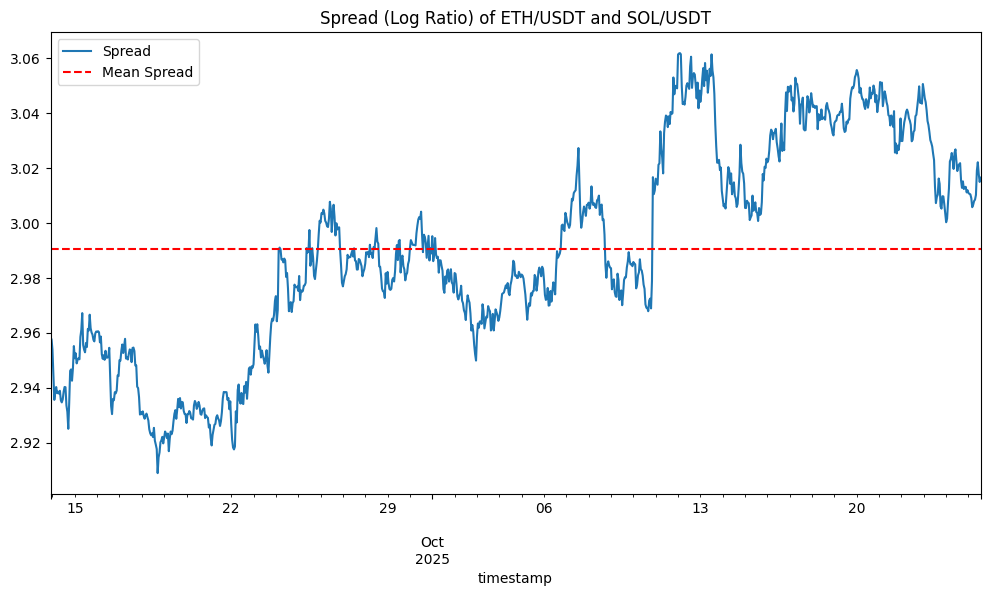

In [12]:
# Plot the Spread to visually inspect for mean reversion
plt.figure(figsize=(12, 6))
data['Spread'].plot(title=f'Spread (Log Ratio) of {SYMBOL_1} and {SYMBOL_2}')
plt.axhline(data['Spread'].mean(), color='red', linestyle='--', label='Mean Spread')
plt.legend()
plt.show()

## Diagnosing and Achieving Stationarity
For statistical arbitrage strategies to work, we need stationarity between the spread of two assets. We need to confirm that the spread is stationary using the Augmented Dickey-Fuller test.

In [13]:
def run_adf_test(series, series_name):
    """Performs the Augmented Dickey-Fuller Test."""
    print("-" * 50)
    print(f"Augmented Dickey-Fuller Test for: {series_name}")
    
    # Run the test
    result = adfuller(series.dropna())
    
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    # Decision Logic
    if result[1] <= 0.05 and result[0] < result[4]['5%']:
        print("\nConclusion: REJECT the Null Hypothesis (Unit Root).")
        print(f"The series ({series_name}) IS LIKELY STATIONARY (mean-reverting).")
    else:
        print("\nConclusion: FAIL TO REJECT the Null Hypothesis (Unit Root).")
        print(f"The series ({series_name}) IS LIKELY NON-STATIONARY (trending).")
    print("-" * 50)

In [14]:
# 1. Test the raw asset (Should be NON-STATIONARY)
run_adf_test(data['Log_ETH'], f'Log Price of {SYMBOL_1}')

--------------------------------------------------
Augmented Dickey-Fuller Test for: Log Price of ETH/USDT
ADF Statistic: -1.8368
p-value: 0.3624
Critical Values:
	1%: -3.4369
	5%: -2.8644
	10%: -2.5683

Conclusion: FAIL TO REJECT the Null Hypothesis (Unit Root).
The series (Log Price of ETH/USDT) IS LIKELY NON-STATIONARY (trending).
--------------------------------------------------


In [ ]:
# 2. Test the Spread (This MUST be STATIONARY for Stat Arb)
run_adf_test(data['Spread'], 'Pair Spread')

--------------------------------------------------
Augmented Dickey-Fuller Test for: Pair Spread
ADF Statistic: -1.8148
p-value: 0.3731
Critical Values:
	1%: -3.4369
	5%: -2.8644
	10%: -2.5683

Conclusion: FAIL TO REJECT the Null Hypothesis (Unit Root).
The series (Pair Spread) IS LIKELY NON-STATIONARY (trending).
--------------------------------------------------


We see that ETH and SOL are likely to be highly correlated, which do not lend them to stat arb. For the purpose of completing this analysis, we will compute their autocorrelation.

## Autocorrelation
Autocorrelation is the measure of how much we can predict the mean reverting property between two assets. We need the autocorrelation to be both predictable and fast, so I believe the sweet spot is usually around 0.5.

We will use:
- Autocorrelation function: measures the correlation between the time series and past values. In an ideal AR(1) spread, we want the autocorrelation to be strong at time lag 1, and it should exponentially decay for longer time spreads.
- Partial autocorrelation function: it measures the autocorrelation between two point in time after removing the linear effects of the values in between. 

We use both measures to see if the autocorrelation occurs at the time lag that we are interested in.

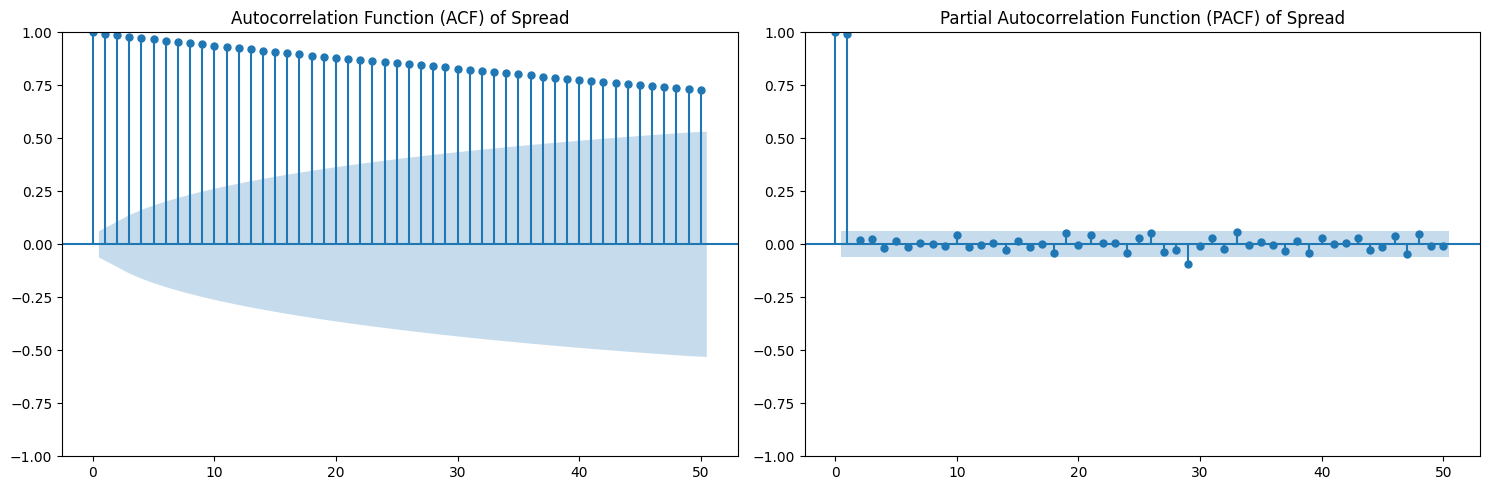

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF: Shows correlation with past values (direct and indirect effects)
plot_acf(data['Spread'].dropna(), lags=50, ax=axes[0], title='Autocorrelation Function (ACF) of Spread')

# PACF: Shows correlation with past values (direct effect only)
plot_pacf(data['Spread'].dropna(), lags=50, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Spread')

plt.tight_layout()
plt.show()

These ACF and PACF plots confirm that the spread between ETH and SOL are non-stationary:
- ACF: it should exponentially decay post 1 time period, but this is not the case
- PACF: a single dominant spike at lag 1, then drop off to close to 0 for subsequent lags. While this is what we want, unfortunately we cannot analyse PACF in isolation. Instead, we need to first confirm with ACF.